# Deep Q-Network (DQN)

The two problems that consistently show up in the naive application of function approximation to RL (NFQ) are the violations of the IID assumption and the non stationarity of targets. In order to overcame thedse limits, DQN introduces two main ideas:
- the use of a replay buffer, to break the correlation between consecutive samples 
- the use of a target network in order to simulate a IID problem and a more stable target

We create the Replay Memory, a data structure D to hold experience samples for several steps. The only difference is that we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D, instead of using the online experiences as before:

In [13]:
from collections import deque

class ReplayMemory():
    def __init__(self, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size
        
        self.states = deque(maxlen=memory_size)
        self.actions = deque(maxlen=memory_size)
        self.rewards = deque(maxlen=memory_size)
        self.next_states = deque(maxlen=memory_size)
        self.is_failures = deque(maxlen=memory_size)

    def store(self, state, action, reward, next_state, is_failure):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.is_failures.append(is_failure)
    
    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        if(batch_size > self.len()): raise Exception("Batch size is greater than the memory size")
        
        idx = np.random.choice(range(self.len()), batch_size, replace=False)        
        states = np.array(self.states)[idx]
        actions = np.array(self.actions)[idx]
        rewards = np.array(self.rewards)[idx]
        next_states = np.array(self.next_states)[idx]
        is_failures = np.array(self.is_failures)[idx]

        return states, actions, rewards, next_states, is_failures

    def len(self):
        return len(self.states)

In practice we don’t have two different networks. The target network is a previous instance of the same neural network that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the online network, which is the network we optimize on every step.

In [14]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))

        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
        # decide the device to be used for training
        device = "cpu"
        if torch.cuda.is_available(): device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        q_values = self.output_layer(x)
        
        return q_values

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state).detach().data.numpy().squeeze()
            action = np.argmax(q_values)
        return action
    

Consider the optimize method of the new algorithm, notice that we use the target network to calculate the Q-values of the next state, but we use the online network to calculate the Q-values of the current state:

In [15]:
def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    states, actions, rewards, next_states, is_failures = memory.sample()

    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the values of the Q-function at next state from the "target" network 
    q_target_next = target_model(next_states).detach()
        
    # get the max value 
    max_q_target_next = q_target_next.max(1)[0].unsqueeze(1)

    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a), here we query the current "online" network
    q_online_current = online_model(states).gather(1, actions) 
    
    # create the errors
    td_errors = target - q_online_current
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

The following is how the target network gets updated with the online network:

In [16]:
def update(target_model, online_model):
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        target.data.copy_(online.data)

To balance the exploration-exploitation trade-off we use a exponentially decaying epsilon-greedy exploration strategy.

In [17]:
def decay_epsilon(max, min, decay_episodes, max_episodes):
    rem_episodes = max_episodes - decay_episodes
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (max - min) * values + min
    values = np.pad(values, (0, rem_episodes), 'edge')
    return values

In [18]:
def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [19]:
def greedy(approximator, state):
    return approximator.select_action(state)

As in NFQ, need a method to evaluate the learned policy using a greedy strategy:

In [20]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

We can now implement the full DQN algorithm, the main difference with NFQ are that we use an exponentially decaying epsilon-greedy strategy to improve policies, we use a replay buffer and a target network. So the algorithm has three main steps:

1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the buffer, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [21]:
import time
import numpy as np
import random
from itertools import count

import gymnasium

def dqn(env_name, seed, replay_memory_size, batch_size, 
        online_optimize_steps, target_update_steps, 
        epsilon_max, epsilon_min, decay_episodes,
        gamma, max_episodes, max_time, max_score, episodes_window):
    
    # create the environment
    env = gymnasium.make(env_name)

    # create the experience replay as a deque object 
    replay_buffer = ReplayMemory(replay_memory_size, batch_size)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the online and target models
    online_model = Approximator(state_size, action_size)
    target_model = Approximator(state_size, action_size)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(online_model.parameters(), lr=0.0005)

    # calculate the decay epsilon
    epsilons = decay_epsilon(epsilon_max, epsilon_min, decay_episodes, max_episodes+1)
    
    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []     

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan   
        
    # synchronize the online and target models at the beginning of training
    update(target_model, online_model)
                    
    # train until we reach the terminal condition (max episodes)
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0

        # reset the environment before starting the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for step in count():

            # select the action using the exploration policy
            action = epsilon_greedy(online_model, state, action_size, epsilons[episode])

            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience into the replay buffer
            replay_buffer.store(state, action, reward, next_state, is_failure)
                
            # sometimes, optimize the online model using the replay buffer
            if step % online_optimize_steps == 0 and replay_buffer.len() > batch_size:
                optimize(replay_buffer, online_model, target_model, optimizer, gamma)
                 
            # sometimes, synchronize the target model with the online model
            if step % target_update_steps == 0:
                update(target_model, online_model)
                
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done:
                break

        # evaluate the learned policy after the episode
        update(target_model, online_model)
        score = evaluate(online_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  
            
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time
            
        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)
            
        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
        
    return online_model, score, results

We can show the performance of DQN on the cart-pole environment in order to show that it is more powerful than NFQ. We can also show that the target network and the replay buffer are important for the stability of the algorithm.

In [22]:
class Experiment():
    def __init__(self, env_name, gamma, 
                 epsilon_max, epsilon_min, decay_episodes,
                 max_episodes, max_time, max_score, episodes_window,
                 replay_memory_size, batch_size, 
                 online_optimize_steps, target_update_steps, 
                 seeds):
        
        self.env_name = env_name
        self.gamma = gamma
        
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_episodes = decay_episodes
        
        self.max_episodes = max_episodes
        self.max_time = max_time
        self.max_score = max_score
        self.episodes_window = episodes_window
        
        self.replay_memory_size = replay_memory_size
        self.batch_size = batch_size
        self.online_optimize_steps = online_optimize_steps
        self.target_update_steps = target_update_steps
        
        self.seeds =seeds
        
    def run(self, algorithm):

        # variables to collect results
        results = []
        best_agent = None
        best_eval_score = float('-inf')
    
        for seed in self.seeds:
    
            # create the agent
            agent, score, result = algorithm(self.env_name, seed, self.replay_memory_size, 
                                             self.batch_size, self.online_optimize_steps, self.target_update_steps,
                                             self.epsilon_max, self.epsilon_min, self.decay_episodes,
                                             self.gamma, self.max_episodes, self.max_time, self.max_score, self.episodes_window)

            # save the results the best agent
            results.append(result)
            if score > best_eval_score:
                best_eval_score = score
                best_agent = agent

        return np.array(results), best_agent, best_eval_score

In [23]:
experiment = Experiment(env_name='CartPole-v1', 
                        gamma=0.99,
                        epsilon_max = 1,
                        epsilon_min = 0.3,
                        decay_episodes = 800,
                        max_episodes = 1000,
                        max_time = 10*60,
                        max_score = 400,
                        episodes_window = 50,
                        replay_memory_size = 1024,
                        batch_size = 32,
                        online_optimize_steps = 1,
                        target_update_steps = 10,
                        seeds = (15, 39, 12, 45, 65))

In [24]:
dqn_results, dqn_agent, dqn_score = experiment.run(dqn)

episode 0251, steps 019188, average score 401.8  --> reached_max_score 
episode 0268, steps 020339, average score 400.7  --> reached_max_score 
episode 0252, steps 017835, average score 402.6  --> reached_max_score 
episode 0583, steps 067608, average score 404.6  --> reached_max_score 
episode 0251, steps 019144, average score 402.7  --> reached_max_score 


We can save the result to future comparison:

In [25]:
np.save('./saved/dqn_results', dqn_results)

We can load the result of NFQ in order to compare the performances of the two algorithms:

In [26]:
nfq_results = np.load('./saved/nfq_results.npy')

We can plot the training reward:

In [27]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

The most obvious conclusion we can draw is that DQN is more sample efficient than NFQ. But, if you pay attention to the curves, you notice how NFQ is also noisier than DQN.

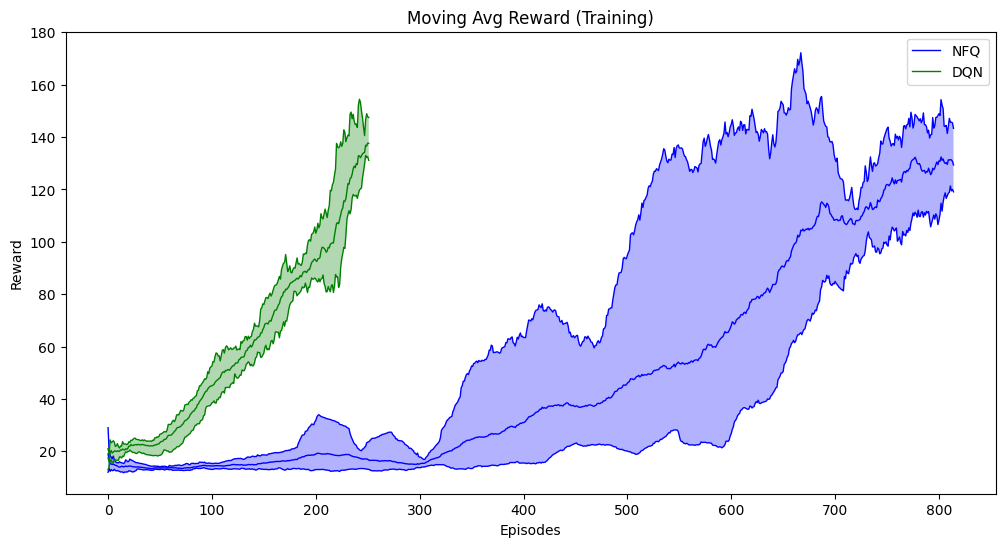

In [28]:
show_result('avg_training_reward','NFQ', nfq_results, 'DQN', dqn_results) 

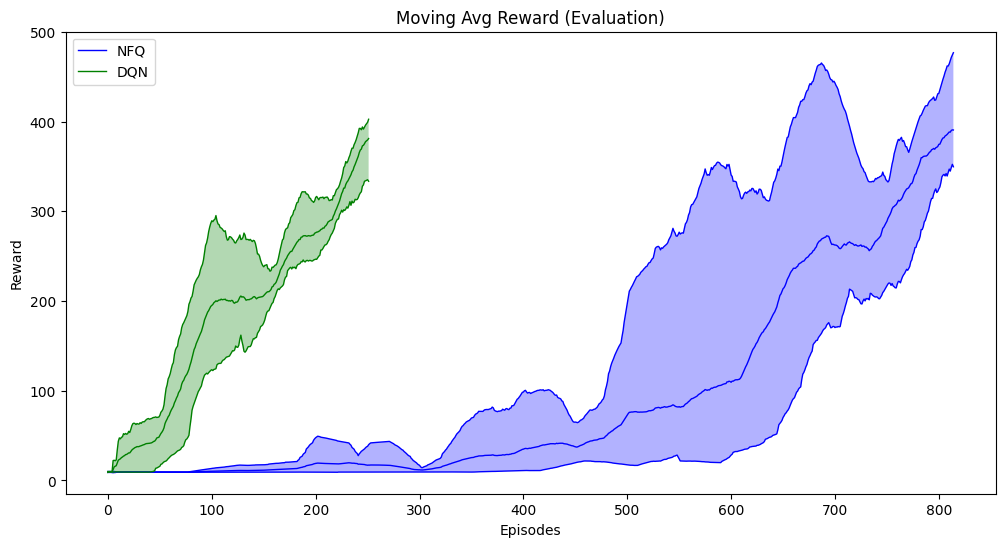

In [29]:
show_result('avg_evaluation_reward','NFQ', nfq_results, 'DQN', dqn_results) 

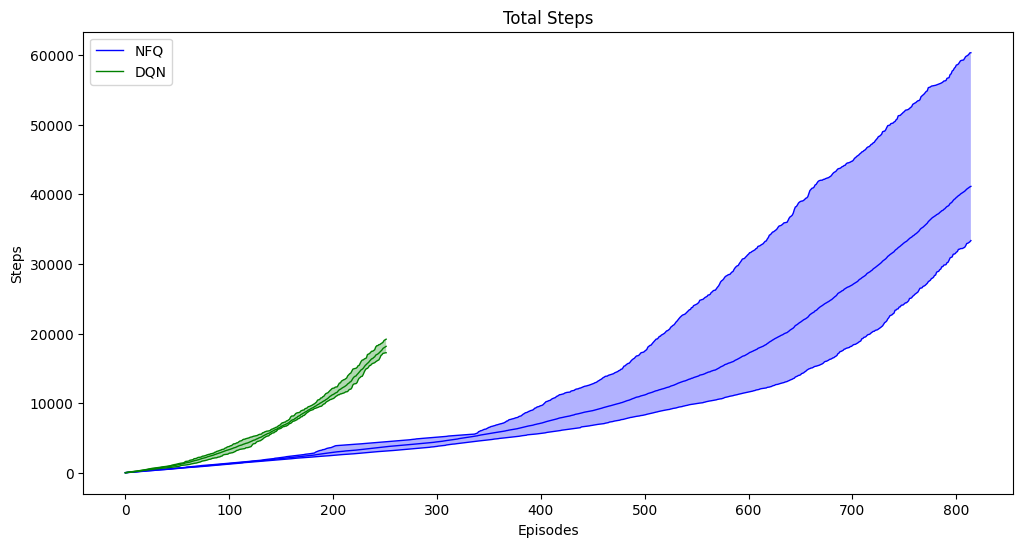

In [30]:
show_result('total_steps','NFQ', nfq_results, 'DQN', dqn_results) 

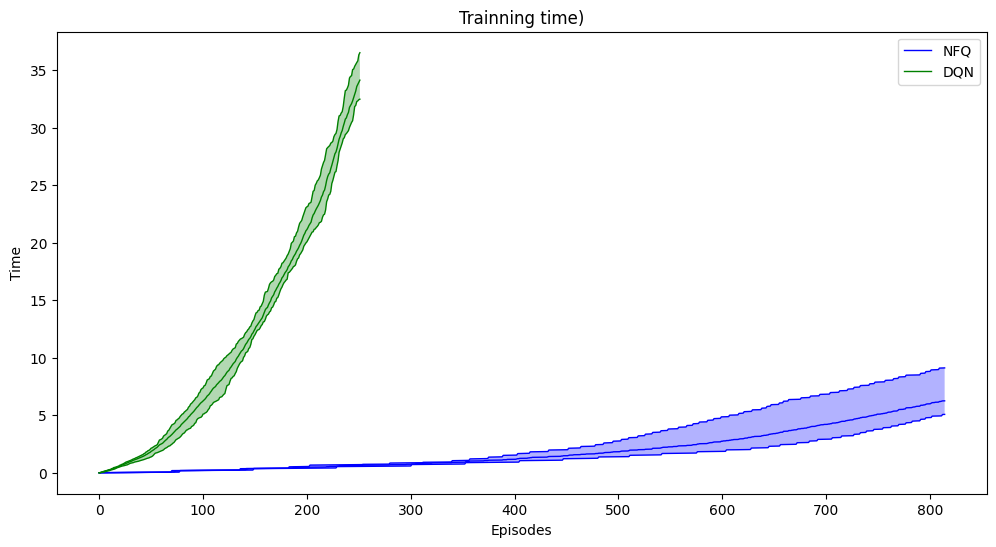

In [31]:
show_result('training_time','NFQ', nfq_results, 'DQN', dqn_results) 